In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

import gym
from tqdm import tqdm_notebook
import numpy as np
from collections import deque

In [ ]:
#discount factor for future utilities
DISCOUNT_FACTOR = 0.99
gamma = 0.99
#number of episodes to run
NUM_EPISODES = 5000

#max steps per episode
MAX_STEPS = 10000

#score agent needs for environment to be solved
SOLVED_SCORE = 475

#device to run model on
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
class PolicyNetwork(nn.Module):
  def __init__(self, observation_space, action_space,seed,layer_size):
        super(PolicyNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.input_layer = nn.Linear(observation_space, layer_size)
        self.output_layer = nn.Linear(layer_size, action_space)
  def forward(self, x):
        x = self.input_layer(x)
        x = F.relu(x)
        actions = self.output_layer(x)
        action_probs = F.softmax(actions, dim=-1)
        return action_probs

In [ ]:

class StateValueNetwork(nn.Module):
    def __init__(self, observation_space,seed,layer_size):
        super(StateValueNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.input_layer = nn.Linear(observation_space, layer_size)
        self.output_layer = nn.Linear(layer_size, 1)
    def forward(self, x):
        x = self.input_layer(x)
        x = F.relu(x)
        state_value = self.output_layer(x)
        return state_value

In [ ]:
def process_rewards(rewards,gamma):
    G = []
    total_r = 0
    for r in reversed(rewards):
        total_r = r + total_r * DISCOUNT_FACTOR
        G.insert(0, total_r)
    G = torch.tensor(G)
    #G = (G - G.mean())/G.std()
    return G

In [ ]:
def train_value(G, state_vals, optimizer):
    val_loss = F.mse_loss(state_vals, G)
    optimizer.zero_grad()
    val_loss.backward()
    optimizer.step()

In [ ]:
#Make environment
#env = gym.make('Acrobot-v1')
env = gym.make('CartPole-v1')
#Init network
'''
policy_network = PolicyNetwork(env.observation_space.shape[0], env.action_space.n)
stateval_network = StateValueNetwork(env.observation_space.shape[0])'''


#Init optimizer


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


'\npolicy_network = PolicyNetwork(env.observation_space.shape[0], env.action_space.n)\nstateval_network = StateValueNetwork(env.observation_space.shape[0])'

In [ ]:
seed_list = [1,42,30,25,17]

In [ ]:
def reset_weights(model):
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

In [ ]:
# Define the objective function
def objective(params):
    eps_list = []
    regret_avg = 0
    reward_per_ep= [0 for i in range(5000)]
    reward_per_ep_list = [[475,475,475,475,475] for i in range(5000)]
    min_ep = 5000
    print(params,"Its just getting started ")
    for iteration in range(5):
      #c= 0
      seed = seed_list[iteration]
      policy_network = PolicyNetwork(env.observation_space.shape[0], env.action_space.n,seed,params["network_size"])
      stateval_network = StateValueNetwork(env.observation_space.shape[0],seed,params["network_size"])
      reset_weights(policy_network)
      reset_weights(stateval_network)
      policy_optimizer = optim.Adam(policy_network.parameters(), params["LR"])
      stateval_optimizer = optim.Adam(stateval_network.parameters(), params["LR"])
      ep = 0
      action_space = np.arange(env.action_space.n)
      total_rewards = []
      avg_rewards_list = []
      regret = 0
      while ep < NUM_EPISODES:
        state = env.reset()
        states = []
        rewards = []
        actions = []
        done = False
        while done == False:
          state = torch.from_numpy(state).float().unsqueeze(0)[0]
          action_probability = policy_network.forward(state).detach().numpy()
          if np.isnan(action_probability).any():
            return float('inf')
          else:
            action = np.random.choice(action_space,p=action_probability)
            state.detach()
            next_state,r,done,_ = env.step(action)
            states.append(state)
            rewards.append(r)
            actions.append(action)
            if done :
              break
            state = next_state
        total_rewards.append(sum(rewards))
        G = process_rewards(rewards,gamma)
        G = torch.FloatTensor(G)
        rewards = torch.FloatTensor(rewards)
        policy_optimizer.zero_grad()
        deltas = [gt for gt in zip(G)]
        deltas = torch.tensor(deltas)
        logprob = [torch.log(policy_network.forward(states[i])) for i in range(len(deltas))]
        policy_loss = []
        for i in range(len(deltas)):
              d = deltas[i]
              lp = logprob[i][actions[i]]
              policy_loss.append(-d * lp)
        policy_optimizer.zero_grad()
        #print(policy_loss,len(actions))
        sum(policy_loss).backward()
        policy_optimizer.step()
        avg_rewards = np.mean(total_rewards[-100:])
        avg_rewards_list.append(avg_rewards)
        ep +=1
        if ep % 400  == 0:
          print("Ep:",ep,"last 100 episodes reward is  :",avg_rewards, end="\n")
        if avg_rewards > 475 :
            #c= 1
            print("problem solved at episode",ep)
            eps_list.append(ep)
            if ep < min_ep:
              min_ep = ep
            break
        regret += 475 - avg_rewards
      for j in range(len(avg_rewards_list)):
            #print(reward_per_ep_list[j])
            reward_per_ep_list[j][iteration] = avg_rewards_list[j]
      print(iteration,params,regret)
      regret_avg += regret
    print("regret_avg:",regret_avg,"for",params)
    for i in range(len(reward_per_ep_list)):
      if len(reward_per_ep_list[i]) == 5:
        #print(reward_per_ep_list[i],"oohoo")
        reward_per_ep[i] = sum(reward_per_ep_list[i])/5
      else:
        k = 5 - len(reward_per_ep_list[i])
        for h in range(k):
          reward_per_ep_list.append(475)
        reward_per_ep[i] = sum(reward_per_ep_list[i])/5
        #print(reward_per_ep[i],'ohoooo')
    return regret_avg/5 , reward_per_ep, min_ep,eps_list,reward_per_ep_list








In [ ]:

params_without_baseline = {"LR": 0.00373 , "network_size": 64}

In [ ]:
L_without_baseline = objective(params_without_baseline)

{'LR': 0.00373, 'network_size': 64} Its just getting started 


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Ep: 400 last 100 episodes reward is  : 291.84
problem solved at episode 624
0 {'LR': 0.00373, 'network_size': 64} 171627.87389433375
Ep: 400 last 100 episodes reward is  : 265.61
problem solved at episode 731
1 {'LR': 0.00373, 'network_size': 64} 198869.60306490393
Ep: 400 last 100 episodes reward is  : 144.38
problem solved at episode 541
2 {'LR': 0.00373, 'network_size': 64} 171776.0339195884
Ep: 400 last 100 episodes reward is  : 460.32
problem solved at episode 514
3 {'LR': 0.00373, 'network_size': 64} 128018.90171249381
Ep: 400 last 100 episodes reward is  : 134.63
problem solved at episode 685
4 {'LR': 0.00373, 'network_size': 64} 194056.25378253276
regret_avg: 864348.6663738528 for {'LR': 0.00373, 'network_size': 64}


In [ ]:
# Define the objective function
def average_over_5_runs(params):
    eps_list = []
    regret_avg = 0
    reward_per_ep= [0 for i in range(5000)]
    reward_per_ep_list = [[475,475,475,475,475] for i in range(5000)]
    min_ep = 5000
    print(params,"Its just getting started ")
    for iteration in range(5):
      #c= 0
      seed = seed_list[iteration]
      policy_network = PolicyNetwork(env.observation_space.shape[0], env.action_space.n,seed,params["network_size"])
      stateval_network = StateValueNetwork(env.observation_space.shape[0],seed,params["network_size"])
      reset_weights(policy_network)
      reset_weights(stateval_network)
      policy_optimizer = optim.Adam(policy_network.parameters(), params["LR"])
      stateval_optimizer = optim.Adam(stateval_network.parameters(), params["LR"])
      ep = 0
      action_space = np.arange(env.action_space.n)
      total_rewards = []
      avg_rewards_list = []
      regret = 0
      while ep < NUM_EPISODES:
        state = env.reset()
        states = []
        rewards = []
        actions = []
        done = False
        while done == False:
          state = torch.from_numpy(state).float().unsqueeze(0)[0]
          action_probability = policy_network.forward(state).detach().numpy()
          if np.isnan(action_probability).any():
            return float('inf')
          else:
            action = np.random.choice(action_space,p=action_probability)
            state.detach()
            next_state,r,done,_ = env.step(action)
            states.append(state)
            rewards.append(r)
            actions.append(action)
            if done :
              break
            state = next_state
        total_rewards.append(sum(rewards))
        G = process_rewards(rewards,gamma)
        G = torch.FloatTensor(G)
        rewards = torch.FloatTensor(rewards)

        policy_optimizer.zero_grad()
        state_vals = []

        for st in states:
          st = st.float().unsqueeze(0)[0]

          state_vals.append(stateval_network(st))
        state_vals = torch.stack(state_vals).squeeze()
        #print(state_vals)
        train_value(G, state_vals, stateval_optimizer)

        deltas = [gt - val for gt, val in zip(G, state_vals)]
        deltas = torch.tensor(deltas)
        policy_optimizer.zero_grad()


        logprob = [torch.log(policy_network.forward(states[i])) for i in range(len(deltas))]
        policy_loss = []
        for i in range(len(deltas)):
              d = deltas[i]
              lp = logprob[i][actions[i]]
              policy_loss.append(-d * lp)
        policy_optimizer.zero_grad()
        #print(policy_loss,len(actions))
        sum(policy_loss).backward()
        policy_optimizer.step()
        avg_rewards = np.mean(total_rewards[-100:])
        avg_rewards_list.append(avg_rewards)
        ep +=1
        if ep % 400  == 0:
          print("Ep:",ep,"last 100 episodes reward is  :",avg_rewards, end="\n")
        if avg_rewards > 475 :
            #c= 1
            print("problem solved at episode",ep)
            eps_list.append(ep)
            if ep < min_ep:
              min_ep = ep
            break
        regret += 475 - avg_rewards
      for j in range(len(avg_rewards_list)):
            #print(reward_per_ep_list[j])
            reward_per_ep_list[j][iteration] = avg_rewards_list[j]
      print(iteration,params,regret)
      regret_avg += regret
    print("regret_avg:",regret_avg,"for",params)
    for i in range(len(reward_per_ep_list)):
      if len(reward_per_ep_list[i]) == 5:
        #print(reward_per_ep_list[i],"oohoo")
        reward_per_ep[i] = sum(reward_per_ep_list[i])/5
      else:
        k = 5 - len(reward_per_ep_list[i])
        for h in range(k):
          reward_per_ep_list.append(475)
        reward_per_ep[i] = sum(reward_per_ep_list[i])/5
        #print(reward_per_ep[i],'ohoooo')
    return regret_avg/5 , reward_per_ep, min_ep,eps_list,reward_per_ep_list








/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
params_with_baseline = {"LR": 0.006808 , "network_size": 64}

In [ ]:
L_with_baseline = average_over_5_runs(params_with_baseline)

{'LR': 0.006808, 'network_size': 64} Its just getting started 
problem solved at episode 276
0 {'LR': 0.006808, 'network_size': 64} 70066.72268092542
problem solved at episode 241
1 {'LR': 0.006808, 'network_size': 64} 65901.48814231872
problem solved at episode 317
2 {'LR': 0.006808, 'network_size': 64} 88758.89109069438
problem solved at episode 239
3 {'LR': 0.006808, 'network_size': 64} 64232.778637767195
problem solved at episode 280
4 {'LR': 0.006808, 'network_size': 64} 85957.39956618939
regret_avg: 374917.2801178951 for {'LR': 0.006808, 'network_size': 64}


average regret =  74983.45602357903


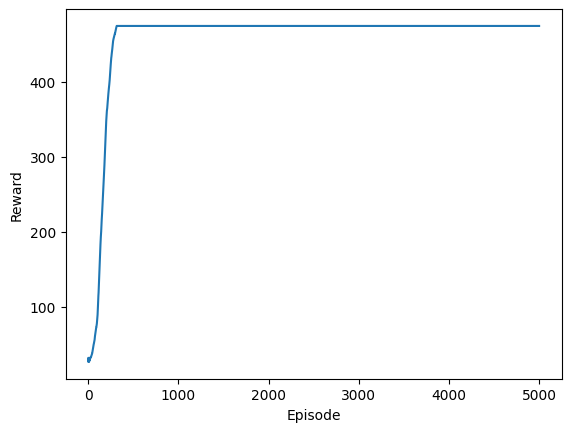

In [ ]:
import matplotlib.pyplot as plt
print("average regret = ",L_with_baseline[0] )
plot_reward =  L_with_baseline[1]
plt.plot(plot_reward)
plt.plot()
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

average regret =  74983.45602357903


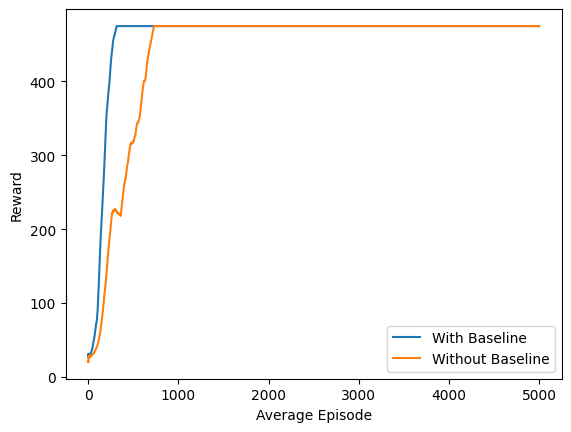

In [ ]:
import matplotlib.pyplot as plt
print("average regret = ",L_with_baseline[0] )

plt.plot(L_with_baseline[1],label='With Baseline')
plt.plot(L_without_baseline[1],label='Without Baseline')
plt.plot()
plt.xlabel('Average Episode')
plt.ylabel('Reward')
plt.legend()
plt.show()

In [ ]:
without_baseline_list=L_without_baseline[-1]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
means_without_baseline = [np.mean(sublist) for sublist in without_baseline_list]
std_devs_without_baseline = [np.std(sublist) for sublist in without_baseline_list]
means_with_baseline = [np.mean(sublist) for sublist in L_with_baseline[-1]]
std_devs_with_baseline = [np.std(sublist) for sublist in L_with_baseline[-1]]

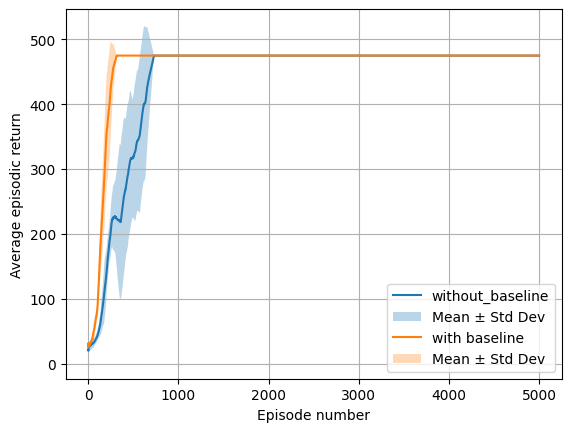

In [ ]:
plt.plot(means_without_baseline, label='without_baseline')
plt.fill_between(range(len(means_without_baseline)), np.subtract(means_without_baseline, std_devs_without_baseline), np.add(means_without_baseline, std_devs_without_baseline), alpha=0.3, label='Mean ± Std Dev')
plt.plot(means_with_baseline, label='with baseline')
plt.fill_between(range(len(means_with_baseline)), np.subtract(means_with_baseline, std_devs_with_baseline), np.add(means_with_baseline, std_devs_with_baseline), alpha=0.3, label='Mean ± Std Dev')
plt.xlabel('Episode number')
plt.ylabel('Average episodic return')
#plt.title('Mean and Standard Deviation of Sublists')
plt.legend()
plt.grid(True)
plt.show()